In [1]:
import os
from pathlib import Path

import jax
import jax.numpy as jnp
from jax import tree_util

import jax_md_mod
from jax_md import space, energy, partition

import optax

import matplotlib.pyplot as plt

from chemtrain.data import preprocessing
from chemtrain.trainers import ForceMatching

base_path = Path(os.environ.get("DATA_PATH", "./data"))

# Force Matching



Force matching is a bottom-up method to derive coarse-grained potentials
$U_\theta$ from atomistic reference data.
In a variational formulation, the approach learns a set of parameters $\theta$
by optimizing the error $\chi^2$ of predicted coarse forces
$\mathbf F_I^\theta(\mathbf R)$ on the coarse-grained sites
$\mathbf R = M(\mathbf r)$ [^Noid2008]

```{math}
\chi^2 = \frac{1}{3N}\left\langle \sum_{I=1}^N \left| \mathbf{\hat{F}}_I^\text{AT} - \mathbf{F}_I^\theta(\mathbf{R})\right|^2 \right\rangle_\text{AT}.
```

## Load Data

In this example, we use reference data from an all-atomistic simulation of
ethane. We obtained this data in the example
[Prior Simulation](./prior_simulation.md).

```{image} ../_static/ethane.png
:align: center
:alt: Ethane
```

<br>

In [2]:
train_ratio = 0.5

box = jnp.asarray([1.0, 1.0, 1.0])

all_forces = preprocessing.get_dataset(base_path / "forces_ethane.npy")
all_positions = preprocessing.get_dataset(base_path / "positions_ethane.npy")

## Compute Mapping

The reference data contains only fine-grained forces $\mathbf f_i$ and positions
$\mathbf r_i$.
Thus, we must define a mapping $M$ that derives the
positions of the coarse-grained sites $\mathcal I_I$ and the forces acting on
them [^Noid2008]

```{math}
\mathbf R_I = \sum_{i \in \mathcal I_I} c_{Ii} \mathbf r_i.
```

We select the two carbon atoms $C_1$ and $C_2$ as locations of the
coarse-grained sites $\mathcal I_1$ and $\mathcal I_2$ and neglect the hydrogen
atoms.
We then compute the effective coarse-grained forces from the atomistic forces
via the corresponding linear mapping [^Noid2008]

```{math}
\mathbf{F}_I = \sum_{i \in \mathcal I_I} \frac{d_{Ii}}{c_{Ii}} \mathbf f_i.
```

In [3]:
# Center of Mass (COM) mapping
displacement_fn, shift_fn = space.periodic_general(box, fractional_coordinates=True)

# Scale the position data into fractional coordinates
position_dataset = preprocessing.scale_dataset_fractional(all_positions, box)

masses = jnp.asarray([15.035, 1.011, 1.011, 1.011])

weights = jnp.asarray([
    [1, 0.0000, 0, 0, 0, 0.000, 0.000, 0.000],
    [0.0000, 1, 0.000, 0.000, 0.000, 0, 0, 0]
])

position_dataset, force_dataset = preprocessing.map_dataset(
    position_dataset, displacement_fn, shift_fn, weights, weights, all_forces 
)

## Setup Model

As a coarse-grained potential model, we choose a simple spring bond

```{math}
    U(\mathbf R) = \frac{1}{2} k_B (|\mathbf R_1 - \mathbf R_2| - b_0)^2.
```

To ensure that the model parameters remain positive during optimization,
we transform them into a constraint space
$\theta_1 = \log b_0,\ \theta_2= \log k_B$.

In [4]:
r_init = position_dataset[0, ...]

displacement_fn, shift_fn = space.periodic_general(box, fractional_coordinates=True)
neighbor_fn = partition.neighbor_list(
    displacement_fn, box, 1.0, fractional_coordinates=True, disable_cell_list=True)

nbrs_init = neighbor_fn.allocate(r_init)

init_params = {
    "log_b0": jnp.log(0.11),
    "log_kb": jnp.log(5000.0)
}

def energy_fn_template(energy_params):
    harmonic_energy_fn = energy.simple_spring_bond(
        displacement_fn, bond=jnp.asarray([[0, 1]]),
        length=jnp.exp(energy_params["log_b0"]),
        epsilon=jnp.exp(energy_params["log_kb"]),
        alpha=2.0
    )
    
    return harmonic_energy_fn    

def force_fn_template(energy_params):
    neg_energy_fn = lambda r, **kwargs: -energy_fn_template(energy_params)(r, **kwargs)
    return jax.grad(neg_energy_fn, argnums=0)

@jax.value_and_grad
def test_loss_fn(params, r, f):
    return jnp.mean(jnp.sum((f - force_fn_template(params)(r, neighbor=nbrs_init)) ** 2, axis=-1))

sample_idx = 0

print(f"Energy with initial params is {energy_fn_template(init_params)(position_dataset[sample_idx, ...], neighbor=nbrs_init)}")
print(f"Forces with initial params are\n{force_fn_template(init_params)(position_dataset[sample_idx, ...], neighbor=nbrs_init)}")
print(f"Parameter gradients on initial sample are\n{test_loss_fn(init_params, position_dataset[sample_idx, ...], force_dataset[sample_idx, ...])[1]}")

/Users/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


Energy with initial params is 0.9190233945846558


Forces with initial params are
[[-10.736445 -90.864784 -28.61029 ]
 [ 10.736445  90.864784  28.61029 ]]


Parameter gradients on initial sample are
{'log_b0': Array(246463.5, dtype=float32, weak_type=True), 'log_kb': Array(-42958.914, dtype=float32, weak_type=True)}


## Analytical Solution

As our model relies only on the magnitude of the displacement between $C_1$ and $C_2$,
we compute this distance and plot it.

Text(0, 0.5, 'Count')

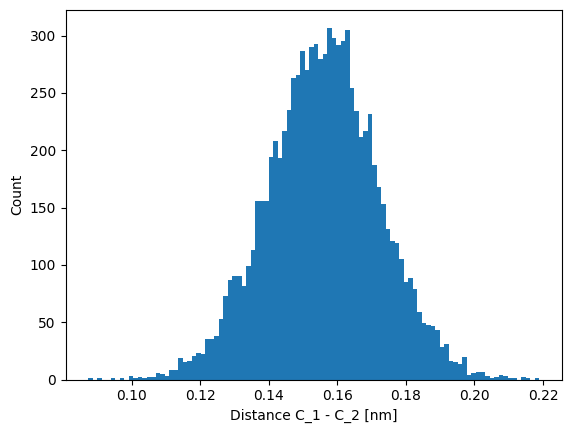

In [5]:
disp = jax.vmap(displacement_fn)(position_dataset[:, 0, :], position_dataset[:, 1, :])
dist_CC = jnp.sqrt(jnp.sum(disp ** 2, axis=-1))

plt.figure()
plt.hist(dist_CC, bins=100)
plt.xlabel("Distance C_1 - C_2 [nm]")
plt.ylabel("Count")

Indeed, the distance between the two carbon atoms is approximately
Gaussian distributed.
Hence, the choice of a harmonic potential model is reasonable.

However, we want to check whether our force data supports this hypothesis.
Therefore, we project the forces onto the displacement vector between the two
carbon atoms.

Text(0, 0.5, 'Projected Force')

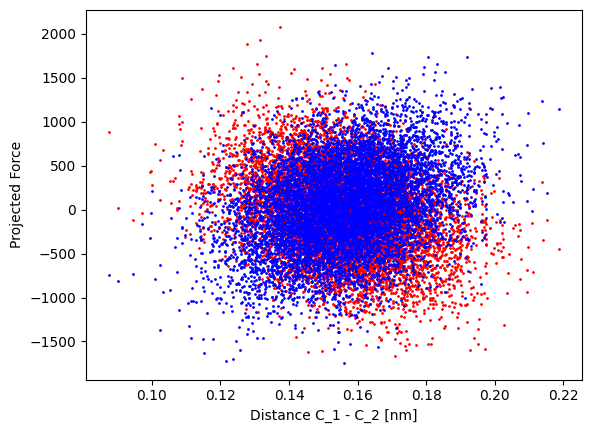

In [6]:
disp_dir = disp / dist_CC[:, None]
force_proj = jnp.einsum('ijk, i...k->ij', force_dataset, disp_dir)

plt.figure()
plt.scatter(dist_CC, force_proj[:, 0], color="r", s=1)
plt.scatter(dist_CC, force_proj[:, 1], color="b", s=1)
plt.xlabel("Distance C_1 - C_2 [nm]")
plt.ylabel("Projected Force")

We see that also the force reference data is quite noisy, but still correlates
with the distance between the coarse-grained sites.

```{math}

\mathbf F_I = (-1)^I k_B (|\mathbf{R}_1 - \mathbf{R}_2| - b_0) \frac{\mathbf{R}_1 - \mathbf{R}_2}{|\mathbf{R}_1 - \mathbf{R}_2|}.
```

Since this relationship is linear, we might estimate the parameters of the model
via a linear regression fit.

In [7]:
# Least squares solution
lhs = jnp.stack((dist_CC, jnp.ones_like(dist_CC)), axis=-1)
rhs = -force_proj[:, (0,)]

kb, c = jnp.linalg.lstsq(lhs, rhs, rcond=None)[0]
b0 = -c / kb

print(f"Estimated potential parameters are {kb[0] :.1f} kJ/mol/nm^2 and {b0[0] :.3f} nm")

Estimated potential parameters are 9659.2 kJ/mol/nm^2 and 0.152 nm


## Setup Optimizer

In [8]:
subsample = 25
batch_per_device = 10
epochs = 20
initial_lr = 0.02
lr_decay = 0.05

lrd = int(position_dataset.shape[0] / subsample / batch_per_device * epochs)
lr_schedule = optax.exponential_decay(initial_lr, lrd, lr_decay)
optimizer = optax.chain(
    optax.scale_by_adam(0.9, 0.95),
    optax.scale_by_schedule(lr_schedule),
    # Flips the sign of the update for gradient descend
    optax.scale_by_learning_rate(1.0),
)

## Setup Force Matching

In [9]:
force_matching = ForceMatching(
    init_params=init_params, energy_fn_template=energy_fn_template,
    nbrs_init=nbrs_init, optimizer=optimizer, batch_per_device=batch_per_device,
)

# We can provide numpy arrays to initialize the datasets for training,
# validation, and testing in a single step
force_matching.set_datasets({
    "F": force_dataset[::subsample, :, :],
    "R": position_dataset[::subsample, :, :],
}, train_ratio=train_ratio)


In [10]:
force_matching.train(epochs, checkpoint_freq=1000)

[Epoch 0]:
	Average train loss: 275324.87934
	Average val loss: 236598.9375
	Gradient norm: 6439788544.0
	Elapsed time = 0.031 min
	Per-target losses:
		F | train loss: 275324.87934027775 | val loss: 236598.9375

[Epoch 1]:
	Average train loss: 273037.12413
	Average val loss: 237960.953125
	Gradient norm: 5256895488.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 273037.12413194444 | val loss: 237960.953125

[Epoch 2]:
	Average train loss: 272265.79167
	Average val loss: 236449.421875
	Gradient norm: 4731447808.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 272265.7916666667 | val loss: 236449.421875

[Epoch 3]:
	Average train loss: 271902.76562
	Average val loss: 236506.40625
	Gradient norm: 156474592.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 271902.765625 | val loss: 236506.40625



[Epoch 4]:
	Average train loss: 271636.87674
	Average val loss: 237217.1875
	Gradient norm: 5472421888.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 271636.8767361111 | val loss: 237217.1875

[Epoch 5]:
	Average train loss: 271395.45399
	Average val loss: 236955.109375
	Gradient norm: 561978176.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 271395.45399305556 | val loss: 236955.109375

[Epoch 6]:
	Average train loss: 271170.84983
	Average val loss: 237614.59375
	Gradient norm: 3819492096.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 271170.8498263889 | val loss: 237614.59375

[Epoch 7]:
	Average train loss: 271153.67274
	Average val loss: 237014.125
	Gradient norm: 26939443200.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 271153.67274305556 | val loss: 237014.125



[Epoch 8]:
	Average train loss: 270810.23264
	Average val loss: 237909.078125
	Gradient norm: 1554359680.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 270810.2326388889 | val loss: 237909.078125

[Epoch 9]:
	Average train loss: 270923.39410
	Average val loss: 238278.9375
	Gradient norm: 7308095488.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 270923.39409722225 | val loss: 238278.9375

[Epoch 10]:
	Average train loss: 270902.26997
	Average val loss: 238088.96875
	Gradient norm: 3503863808.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 270902.26996527775 | val loss: 238088.96875

[Epoch 11]:
	Average train loss: 270788.86979
	Average val loss: 238498.203125
	Gradient norm: 2576067072.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 270788.8697916667 | val loss: 238498.203125



[Epoch 12]:
	Average train loss: 270903.87587
	Average val loss: 238362.5625
	Gradient norm: 22409934848.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 270903.87586805556 | val loss: 238362.5625

[Epoch 13]:
	Average train loss: 270733.37500
	Average val loss: 238220.640625
	Gradient norm: 1508411008.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 270733.375 | val loss: 238220.640625

[Epoch 14]:
	Average train loss: 270762.36719
	Average val loss: 238545.484375
	Gradient norm: 887819840.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 270762.3671875 | val loss: 238545.484375

[Epoch 15]:
	Average train loss: 270722.80469
	Average val loss: 238412.5
	Gradient norm: 8280138240.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 270722.8046875 | val loss: 238412.5



[Epoch 16]:
	Average train loss: 270811.31684
	Average val loss: 238602.0625
	Gradient norm: 7095881216.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 270811.31684027775 | val loss: 238602.0625

[Epoch 17]:
	Average train loss: 270706.23611
	Average val loss: 238186.5
	Gradient norm: 32078110720.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 270706.2361111111 | val loss: 238186.5

[Epoch 18]:
	Average train loss: 270756.25955
	Average val loss: 238383.546875
	Gradient norm: 6668497408.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 270756.2595486111 | val loss: 238383.546875

[Epoch 19]:
	Average train loss: 270709.96615
	Average val loss: 238588.375
	Gradient norm: 110710288.0
	Elapsed time = 0.001 min
	Per-target losses:
		F | train loss: 270709.9661458333 | val loss: 238588.375



In [11]:
# We can also provide completely new samples for a single stage, e.g., testing
force_matching.set_dataset({
    "F": force_dataset[1::subsample, :, :],
    "R": position_dataset[1::subsample, :, :],
}, stage = "testing")

mae_error = force_matching.evaluate_mae_testset()
print(mae_error)

F: MAE = 437.8789
None


## Results

Text(0, 0.5, 'Force Error')

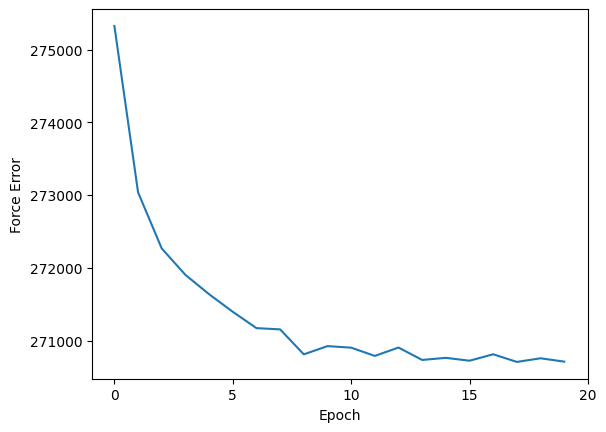

In [12]:
plt.plot(force_matching.train_losses)
plt.xticks(ticks=range(0, epochs + 1, 5))
plt.xlabel("Epoch")
plt.ylabel("Force Error")

Finally, we compare the values obtained from a least-squares fit to those
obtained from force-matching.

In [13]:
pred_parameters = tree_util.tree_map(jnp.exp, force_matching.params)

b0_err = jnp.abs(b0[0] - pred_parameters["log_b0"])
kb_err = jnp.abs(kb[0] - pred_parameters["log_kb"])

print(f"Force matching predicted {pred_parameters['log_b0']:.3f} nm and {pred_parameters['log_kb']:.1f} kJ/mol/nm^2")
print(f"Least squares predicted {b0[0]:.3f} nm and {kb[0]:.1f} kJ/mol/nm^2")
print(f"Absolute error in b0 is {b0_err:.3f} nm and in kb is {kb_err:.1f} kJ/mol/nm^2")

Force matching predicted 0.153 nm and 8476.0 kJ/mol/nm^2
Least squares predicted 0.152 nm and 9659.2 kJ/mol/nm^2
Absolute error in b0 is 0.000 nm and in kb is 1183.2 kJ/mol/nm^2


## Further Reading

### Examples

- [Alanine Dipeptide in Implicit Water](../examples/CG_alanine_dipeptide.ipynb)

### Publications

1. Stephan Thaler, Maximilian Stupp, Julija Zavadlav; *Deep coarse-grained potentials via relative entropy minimization*. J. Chem. Phys. 28 December 2022; 157 (24): 244103. <https://doi.org/10.1063/5.0124538>

## References

[^Noid2008]: W. G. Noid, Jhih-Wei Chu, Gary S. Ayton, Vinod Krishna, Sergei Izvekov, Gregory A. Voth, Avisek Das, Hans C. Andersen; *The multiscale coarse-graining method. I. A rigorous bridge between atomistic and coarse-grained models*. J. Chem. Phys. 28 June 2008; 128 (24): 244114. https://doi-org.eaccess.tum.edu/10.1063/1.2938860